In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Problem Description

I'm Something of a Painter Myself consists of 
* 7028 photos and 
* 300 monet paintings

Each image being 256x256x3. The goal of this project is to use GANs to create Monet-like paintings of the real photos. This will be done by creating a generator that creates predictions (monet-like photos) and a discriminator that compares the predicted photos and monet photos and predicts which it thinks is real.

# Download Dataset from Kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cfildish","key":"8ca6473514bc11e567523864fedacee5"}'}

In [4]:
!pip install -q kaggle

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c gan-getting-started

 91% 335M/367M [00:00<00:00, 1.76GB/s]
100% 367M/367M [00:00<00:00, 1.75GB/s]


In [8]:
# Unzip the downloaded dataset
!unzip -oq /content/gan-getting-started.zip

# List the contents to find the CSV file (optional, but good for verification)
!ls



drive			 kaggle.json  monet_tfrec  photo_tfrec
gan-getting-started.zip  monet_jpg    photo_jpg    sample_data


In [9]:
monet_files = tf.io.gfile.glob(str('monet_tfrec/*.tfrec'))
photo_files = tf.io.gfile.glob(str('photo_tfrec/*.tfrec'))

In [10]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = (tf.cast(image, tf.float32) / 127.5) - 1
  image = tf.reshape(image, [*IMAGE_SIZE, 3])
  return image

def read_tfrecord(example):
  tfrecord_format = {
      "image_name": tf.io.FixedLenFeature([], tf.string),
      "image": tf.io.FixedLenFeature([], tf.string),
      "target": tf.io.FixedLenFeature([], tf.string)
  }
  example = tf.io.parse_single_example(example, tfrecord_format)
  image = decode_image(example['image'])
  return image

def load_dataset(filenames):
  AUTOTUNE = tf.data.experimental.AUTOTUNE
  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
  return dataset

In [11]:
monet_ds = load_dataset(monet_files).batch(1)
photo_ds = load_dataset(photo_files).batch(1)


# EDA

## Example Monet Images

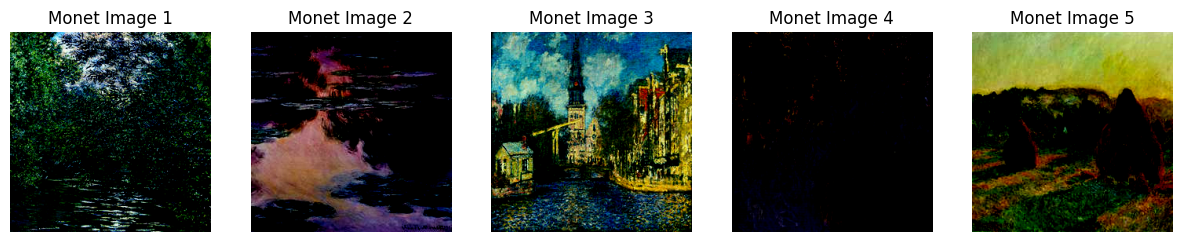

In [28]:
plt.figure(figsize=(15, 5))
for i, image_batch in enumerate(monet_ds.take(5)): # Take 5 batches, each containing one image
  plt.subplot(1, 5, i + 1) # 1 row, 5 columns, current image index
  plt.imshow((image_batch[0].numpy() * 0.5) + 0.5)
  plt.title(f"Monet Image {i+1}")
  plt.axis("off")
plt.show()

## Example Photos

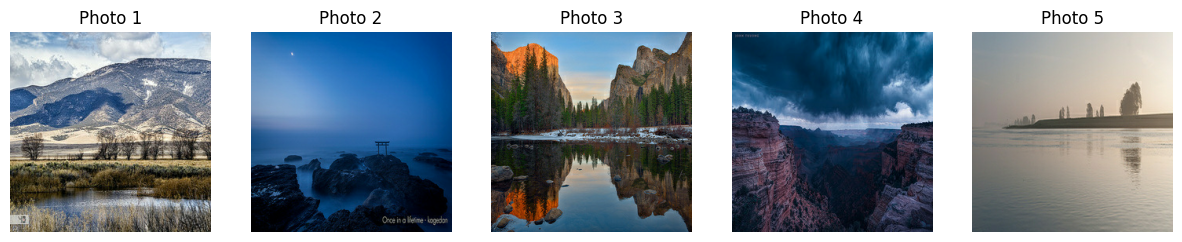

In [29]:
plt.figure(figsize=(15, 5))
for i, image_batch in enumerate(photo_ds.take(5)): # Take 5 batches, each containing one image
  plt.subplot(1, 5, i + 1) # 1 row, 5 columns, current image index
  plt.imshow((image_batch[0].numpy() * 0.5) + 0.5)
  plt.title(f"Photo {i+1}")
  plt.axis("off")
plt.show()

# Model Architecture

We start by using a similar architecture as the example in the Kaggle competition, with the following updates and changes implemented:
* Add on additional convolution layer to the downsample step 
* Add two transpose layers in the upsample step
* Introducing a negative slope to the leaky relu function
* apply_dropout=True to more layers since we've added more convolutional 2D layers
* I had issues downloading Tensorflow Addons in Google Colab, so I used LayerNormalization() from tensorflow as a substitute.

In [12]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = keras.Sequential()
  result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                            kernel_initializer=initializer, use_bias=False))
  # Added additional convolution layer with strides=1
  result.add(layers.Conv2D(filters, size, strides=1, padding='same',
                            kernel_initializer=initializer, use_bias=False))
  if apply_instancenorm:
      result.add(tf.keras.layers.LayerNormalization())
  result.add(layers.LeakyReLU(negative_slope=0.2))

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  # Removed gamma_init as per instruction

  result = keras.Sequential()
  result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  # Added additional transpose convolution layer with strides=1
  result.add(layers.Conv2DTranspose(filters, size, strides=1,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  # Modified LayerNormalization to remove gamma_initializer
  result.add(tf.keras.layers.LayerNormalization())
  if apply_dropout:
      result.add(layers.Dropout(0.5))
  result.add(layers.LeakyReLU(negative_slope=0.2))

  return result

In [13]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  # gamma_init is no longer needed if using default LayerNormalization

  inp = layers.Input(shape=[256, 256, 3], name='input_image')

  x = inp

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = layers.Conv2D(512, 4, strides=1,
                        kernel_initializer=initializer,
                        use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  norm1 = tf.keras.layers.LayerNormalization()(conv) # Changed to default initializer

  leaky_relu = layers.LeakyReLU(negative_slope=0.2)(norm1)

  zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = layers.Conv2D(1, 4, strides=1,
                        kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=inp, outputs=last)

In [14]:
def Generator():
  inputs = layers.Input(shape=[256,256,3])

  # bs = batch size
  down_stack = [
      downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
      downsample(128, 4), # (bs, 64, 64, 128)
      downsample(256, 4), # (bs, 32, 32, 256)
      downsample(512, 4), # (bs, 16, 16, 512)
      downsample(512, 4), # (bs, 8, 8, 512)
      downsample(512, 4), # (bs, 4, 4, 512)
      downsample(512, 4), # (bs, 2, 2, 512)
      downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
      upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
      upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
      upsample(512, 4, apply_dropout=True), # (bs, 16, 16, 1024) - Added Dropout
      upsample(256, 4, apply_dropout=True), # (bs, 32, 32, 512) - Added Dropout
      upsample(128, 4), # (bs, 64, 64, 256)
      upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                strides=2,
                                padding='same',
                                kernel_initializer=initializer,
                                activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
      x = down(x)
      skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
      x = up(x)
      x = layers.Concatenate()([x, skip])

  x = last(x)

  return keras.Model(inputs=inputs, outputs=x)

In [15]:
monet_generator = Generator() # transforms photos to Monet-esque paintings
photo_generator = Generator() # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photo

#### Originally decided to use WGAN without knowing it is a noise-to-image translator

In [16]:
BATCH_SIZE = 1

monet_ds = load_dataset(monet_files).batch(BATCH_SIZE)
photo_ds = load_dataset(photo_files).batch(BATCH_SIZE)


In [17]:
def build_wgan_generator(latent_dim, output_channels, image_size):
  model = keras.Sequential(
      [
          keras.Input(shape=(latent_dim,)),
          layers.Dense(4 * 4 * 1024),
          layers.Reshape((4, 4, 1024)),
          # Upsample to 8x8
          layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same", use_bias=False),
          tf.keras.layers.LayerNormalization(), # Changed to default initializer
          layers.LeakyReLU(negative_slope=0.2),
          # Upsample to 16x16
          layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False),
          tf.keras.layers.LayerNormalization(), # Changed to default initializer
          layers.LeakyReLU(negative_slope=0.2),
          # Upsample to 32x32
          layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False),
          tf.keras.layers.LayerNormalization(), # Changed to default initializer
          layers.LeakyReLU(negative_slope=0.2),
          # Upsample to 64x64
          layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False),
          tf.keras.layers.LayerNormalization(), # Changed to default initializer
          layers.LeakyReLU(negative_slope=0.2),
          # Upsample to 128x128
          layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same", use_bias=False),
          tf.keras.layers.LayerNormalization(), # Changed to default initializer
          layers.LeakyReLU(negative_slope=0.2),
          # Upsample to 256x256
          layers.Conv2DTranspose(output_channels, kernel_size=4, strides=2, padding="same", activation="tanh"),
      ],
      name="wgan_generator",
  )
  return model

print("Defined the `build_wgan_generator` function.")

Defined the `build_wgan_generator` function.


In [17]:
latent_dim = 128 # Define latent_dim here for immediate use
monet_generator = Generator()
photo_generator = Generator()

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photo


Implement Architecture

In [20]:
class WGAN(keras.Model):
  def __init__(
    self,
    monet_generator,
    photo_generator,
    monet_discriminator,
    photo_discriminator,
    latent_dim,
    discriminator_extra_steps=3,
    gp_weight=1,
  ):
    super(WGAN, self).__init__()
    self.m_gen = monet_generator
    self.p_gen = photo_generator
    self.m_disc = monet_discriminator
    self.p_disc = photo_discriminator
    self.latent_dim = latent_dim
    self.d_steps = discriminator_extra_steps
    self.gp_weight = gp_weight

  def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer,
              p_disc_optimizer, gen_loss_fn, disc_loss_fn):
    super().compile()
    self.m_gen_optimizer = m_gen_optimizer
    self.p_gen_optimizer = p_gen_optimizer
    self.m_disc_optimizer = m_disc_optimizer
    self.p_disc_optimizer = p_disc_optimizer
    self.gen_loss_fn = gen_loss_fn
    self.disc_loss_fn = disc_loss_fn

  def gradient_penalty(self, batch_size, real_images, fake_images, discriminator):
    # Get the interpolated image
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator(interpolated, training=True)

    # 2. Calculate the gradients w.r.t the interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

  def train_step(self, batch_data):
    real_monet, real_photo = batch_data

    # Get the batch size
    batch_size_monet = tf.shape(real_monet)[0]
    batch_size_photo = tf.shape(real_photo)[0]

    # Train Discriminators
    for i in range(self.d_steps):
      # Train Monet Discriminator
      random_latent_vectors_monet = tf.random.normal(shape=(batch_size_monet, self.latent_dim))
      with tf.GradientTape() as tape:
        fake_monet = self.m_gen(random_latent_vectors_monet, training=False)
        d_fake_monet = self.m_disc(fake_monet, training=True)
        d_real_monet = self.m_disc(real_monet, training=True)
        d_cost_monet = self.disc_loss_fn(d_real_monet, d_fake_monet)
        gp_monet = self.gradient_penalty(batch_size_monet, real_monet, fake_monet, self.m_disc)
        monet_d_loss = d_cost_monet + gp_monet * self.gp_weight

      monet_d_gradient = tape.gradient(monet_d_loss, self.m_disc.trainable_variables)
      self.m_disc_optimizer.apply_gradients(zip(monet_d_gradient, self.m_disc.trainable_variables))

      # Train Photo Discriminator
      random_latent_vectors_photo = tf.random.normal(shape=(batch_size_photo, self.latent_dim))
      with tf.GradientTape() as tape:
        fake_photo = self.p_gen(random_latent_vectors_photo, training=False)
        d_fake_photo = self.p_disc(fake_photo, training=True)
        d_real_photo = self.p_disc(real_photo, training=True)
        d_cost_photo = self.disc_loss_fn(d_real_photo, d_fake_photo)
        gp_photo = self.gradient_penalty(batch_size_photo, real_photo, fake_photo, self.p_disc)
        photo_d_loss = d_cost_photo + gp_photo * self.gp_weight

      photo_d_gradient = tape.gradient(photo_d_loss, self.p_disc.trainable_variables)
      self.p_disc_optimizer.apply_gradients(zip(photo_d_gradient, self.p_disc.trainable_variables))

    # Train Generators
    # Train Monet Generator
    random_latent_vectors_monet = tf.random.normal(shape=(batch_size_monet, self.latent_dim))
    with tf.GradientTape() as tape:
      fake_monet = self.m_gen(random_latent_vectors_monet, training=True)
      d_fake_monet = self.m_disc(fake_monet, training=False)
      monet_g_loss = self.gen_loss_fn(d_fake_monet)

    monet_g_gradient = tape.gradient(monet_g_loss, self.m_gen.trainable_variables)
    self.m_gen_optimizer.apply_gradients(zip(monet_g_gradient, self.m_gen.trainable_variables))

    # Train Photo Generator
    random_latent_vectors_photo = tf.random.normal(shape=(batch_size_photo, self.latent_dim))
    with tf.GradientTape() as tape:
      fake_photo = self.p_gen(random_latent_vectors_photo, training=True)
      d_fake_photo = self.p_disc(fake_photo, training=False)
      photo_g_loss = self.gen_loss_fn(d_fake_photo)

    photo_g_gradient = tape.gradient(photo_g_loss, self.p_gen.trainable_variables)
    self.p_gen_optimizer.apply_gradients(zip(photo_g_gradient, self.p_gen.trainable_variables))

    return {
            "monet_gen_loss": monet_g_loss,
            "photo_gen_loss": photo_g_loss,
            "monet_disc_loss": monet_d_loss,
            "photo_disc_loss": photo_d_loss
        }

In [21]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
monet_generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.00005, beta_1=0.5, beta_2=0.9
)
photo_generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.00005, beta_1=0.5, beta_2=0.9
)

monet_discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.00005, beta_1=0.0, beta_2=0.9 # Changed beta_1 to 0.0 for discriminator stability
)
photo_discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.00005, beta_1=0.0, beta_2=0.9 # Changed beta_1 to 0.0 for discriminator stability
)


# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for training.
epochs = 30

noise_dim = 128

# Get the wgan model
wgan = WGAN(
    monet_discriminator=monet_discriminator,
    monet_generator=monet_generator,
    photo_discriminator=photo_discriminator,
    photo_generator=photo_generator,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    m_disc_optimizer=monet_discriminator_optimizer,
    m_gen_optimizer=monet_generator_optimizer,
    p_disc_optimizer=photo_discriminator_optimizer,
    p_gen_optimizer=photo_generator_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
)


In [22]:
# Start training
wgan.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), batch_size=BATCH_SIZE, epochs=epochs)


Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 99s 57ms/step - monet_disc_loss: 55.7689 - monet_gen_loss: 0.0414 - photo_disc_loss: 38.0550 - photo_gen_loss: -1.2054
Epoch 2/30
  2/300 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - monet_disc_loss: 0.0976 - monet_gen_loss: -0.2511 - photo_disc_loss: 0.0100 - photo_gen_loss: -1.3454

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - monet_disc_loss: 0.1829 - monet_gen_loss: -0.5701 - photo_disc_loss: 0.0793 - photo_gen_loss: -1.5800
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - monet_disc_loss: 0.1354 - monet_gen_loss: -1.2805 - photo_disc_loss: 0.1292 - photo_gen_loss: -2.6574
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - monet_disc_loss: 0.0935 - monet_gen_loss: -1.5050 - photo_disc_loss: 0.1020 - photo_gen_loss: -3.1220
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - monet_disc_loss: 0.0798 - monet_gen_loss: -1.6921 - photo_disc_loss: 0.0783 - photo_gen_loss: -3.4964
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - monet_disc_loss: 0.0718 - monet_gen_loss: -1.8079 - photo_disc_loss: 0.0580 - photo_gen_loss: -3.9332
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - monet_disc_loss: 0.0995 - monet_gen_loss: -1.9311 - photo_disc_loss: 0.0493 - photo_gen_loss: -4.0517
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - monet_d

In [24]:
wgan.save('/content/drive/MyDrive/Colab Notebooks/wgan_model.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [28]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12)) # 4 rows, 5 columns

# Row 1: Real Monet Images
for i, image_batch in enumerate(monet_ds.take(5)):
  axes[0, i].imshow((image_batch[0].numpy() * 0.5) + 0.5)
  axes[0, i].set_title(f"Real Monet {i+1}")
  axes[0, i].axis("off")

# Row 2: Generated Monet Images (from noise)
for i in range(5):
    random_latent_vector = tf.random.normal(shape=(1, latent_dim))
    prediction = monet_generator(random_latent_vector, training=False)[0].numpy()
    prediction = (prediction * 0.5) + 0.5
    axes[1, i].imshow(prediction)
    axes[1, i].set_title(f"Generated Monet {i+1}")
    axes[1, i].axis("off")

# Row 3: Real Photo Images
for i, image_batch in enumerate(photo_ds.take(5)):
  axes[2, i].imshow((image_batch[0].numpy() * 0.5) + 0.5)
  axes[2, i].set_title(f"Real Photo {i+1}")
  axes[2, i].axis("off")

# Row 4: Generated Photo Images (from noise)
for i in range(5):
    random_latent_vector = tf.random.normal(shape=(1, latent_dim))
    prediction = photo_generator(random_latent_vector, training=False)[0].numpy()
    prediction = (prediction * 0.5) + 0.5
    axes[3, i].imshow(prediction)
    axes[3, i].set_title(f"Generated Photo {i+1}")
    axes[3, i].axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### Learning I needed an image-to-image translator, I pivoted to using CycleGAN

In [16]:
class CycleGan(keras.Model):
  def __init__(
    self,
    monet_generator,
    photo_generator,
    monet_discriminator,
    photo_discriminator,
    lambda_cycle=10,
  ):
    super(CycleGan, self).__init__()
    self.m_gen = monet_generator
    self.p_gen = photo_generator
    self.m_disc = monet_discriminator
    self.p_disc = photo_discriminator
    self.lambda_cycle = lambda_cycle

  def compile(
    self,
    m_gen_optimizer,
    p_gen_optimizer,
    m_disc_optimizer,
    p_disc_optimizer,
    gen_loss_fn,
    disc_loss_fn,
    cycle_loss_fn,
    identity_loss_fn
  ):
    super(CycleGan, self).compile()
    self.m_gen_optimizer = m_gen_optimizer
    self.p_gen_optimizer = p_gen_optimizer
    self.m_disc_optimizer = m_disc_optimizer
    self.p_disc_optimizer = p_disc_optimizer
    self.gen_loss_fn = gen_loss_fn
    self.disc_loss_fn = disc_loss_fn
    self.cycle_loss_fn = cycle_loss_fn
    self.identity_loss_fn = identity_loss_fn

  def train_step(self, batch_data):
    real_monet, real_photo = batch_data

    with tf.GradientTape(persistent=True) as tape:
      # photo to monet back to photo
      fake_monet = self.m_gen(real_photo, training=True)
      cycled_photo = self.p_gen(fake_monet, training=True)

      # monet to photo back to monet
      fake_photo = self.p_gen(real_monet, training=True)
      cycled_monet = self.m_gen(fake_photo, training=True)

      # generating itself
      same_monet = self.m_gen(real_monet, training=True)
      same_photo = self.p_gen(real_photo, training=True)

      # discriminator used to check, inputing real images
      disc_real_monet = self.m_disc(real_monet, training=True)
      disc_real_photo = self.p_disc(real_photo, training=True)

      # discriminator used to check, inputing fake images
      disc_fake_monet = self.m_disc(fake_monet, training=True)
      disc_fake_photo = self.p_disc(fake_photo, training=True)

      # evaluates generator loss
      monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
      photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

      # evaluates total cycle consistency loss
      total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

      # evaluates total generator loss
      total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
      total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

      # evaluates discriminator loss
      monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
      photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

    # Gradients for generator and discriminator
    monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                              self.m_gen.trainable_variables)
    photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                              self.p_gen.trainable_variables)

    monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                  self.m_disc.trainable_variables)
    photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                  self.p_disc.trainable_variables)

    # Apply the gradients to the optimizer
    self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                              self.m_gen.trainable_variables))

    self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                              self.p_gen.trainable_variables))

    self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                              self.m_disc.trainable_variables))

    self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                              self.p_disc.trainable_variables))

    return {
              "monet_gen_loss": total_monet_gen_loss,
              "photo_gen_loss": total_photo_gen_loss,
              "monet_disc_loss": monet_disc_loss,
              "photo_disc_loss": photo_disc_loss
          }


In [17]:
def discriminator_loss(real, generated):
  real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

  generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [18]:
def generator_loss(generated):
  return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)


In [19]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [20]:
def identity_loss(real_image, same_image, LAMBDA):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [21]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)


In [23]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 156s 157ms/step - monet_disc_loss: 0.7293 - monet_gen_loss: 5.6257 - photo_disc_loss: 0.7274 - photo_gen_loss: 5.7301
Epoch 2/25
  1/300 ━━━━━━━━━━━━━━━━━━━━ 54s 181ms/step - monet_disc_loss: 0.6011 - monet_gen_loss: 4.7004 - photo_disc_loss: 0.7054 - photo_gen_loss: 3.6807

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - monet_disc_loss: 0.6871 - monet_gen_loss: 3.9228 - photo_disc_loss: 0.6817 - photo_gen_loss: 3.9001
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - monet_disc_loss: 0.6865 - monet_gen_loss: 3.6372 - photo_disc_loss: 0.6735 - photo_gen_loss: 3.6967
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - monet_disc_loss: 0.6816 - monet_gen_loss: 3.3922 - photo_disc_loss: 0.6670 - photo_gen_loss: 3.5060
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - monet_disc_loss: 0.6730 - monet_gen_loss: 3.1855 - photo_disc_loss: 0.6616 - photo_gen_loss: 3.2638
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - monet_disc_loss: 0.6648 - monet_gen_loss: 3.1428 - photo_disc_loss: 0.6599 - photo_gen_loss: 3.1973
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - monet_disc_loss: 0.6599 - monet_gen_loss: 3.0984 - photo_disc_loss: 0.6559 - photo_gen_loss: 3.1576
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - monet_disc_l

### Avg Discriminator Loss- .59935, Avg Generator Loss- 2.61495

Save the model to One Drive

In [31]:
cycle_gan_model.save('/content/drive/MyDrive/Colab Notebooks/cycle_gan_1.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


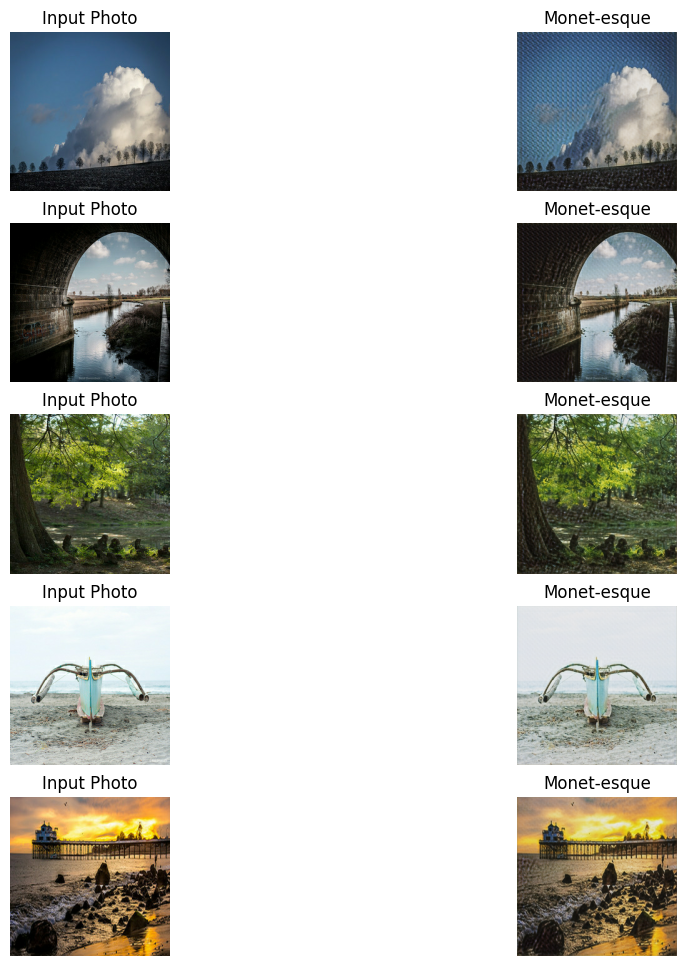

In [32]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Iterate on the CycleGAN Model

Here are some of the updates I add:
* Add more layers to the Discriminator model
* Reduce the number of layers used in the Generator() function
* Tweak some the filter sizes
* Increase the number of epochs in the model

We choose the model that minimizes the discriminator and generator loss for submission to Kaggle

In [19]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  # gamma_init is no longer needed if using default LayerNormalization

  inp = layers.Input(shape=[256, 256, 3], name='input_image')

  x = inp

  down1 = downsample(128, 4, False)(x) # (bs, 128, 128, 128) - Filter size updated
  down2 = downsample(256, 4)(down1) # (bs, 64, 64, 256) - Filter size updated
  down3 = downsample(512, 4)(down2) # (bs, 32, 32, 512) - Filter size updated
  down4 = downsample(512, 4)(down3) # (bs, 16, 16, 512) - New layer added

  zero_pad1 = layers.ZeroPadding2D()(down4) # (bs, 18, 18, 512) - Input changed from down3 to down4
  conv = layers.Conv2D(512, 4, strides=1,
                        kernel_initializer=initializer,
                        use_bias=False)(zero_pad1) # (bs, 15, 15, 512)

  norm1 = tf.keras.layers.LayerNormalization()(conv) # Changed to default initializer

  leaky_relu = layers.LeakyReLU(negative_slope=0.2)(norm1)

  zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 17, 17, 512)

  last = layers.Conv2D(1, 4, strides=1,
                        kernel_initializer=initializer)(zero_pad2) # (bs, 14, 14, 1)

  return tf.keras.Model(inputs=inp, outputs=last)


In [22]:
def Generator():
  inputs = layers.Input(shape=[256,256,3])

  # bs = batch size
  down_stack = [
      downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
      downsample(128, 4), # (bs, 64, 64, 128)
      downsample(256, 4), # (bs, 32, 32, 256)
      downsample(512, 4), # (bs, 16, 16, 512)
  ]

  up_stack = [
      upsample(512, 4, apply_dropout=True), # (bs, 16, 16, 1024) - Added Dropout
      upsample(256, 4, apply_dropout=True), # (bs, 32, 32, 512) - Added Dropout
      upsample(128, 4), # (bs, 64, 64, 256)
      upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                strides=2,
                                padding='same',
                                kernel_initializer=initializer,
                                activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
      x = down(x)
      skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
      x = up(x)
      x = layers.Concatenate()([x, skip])

  x = last(x)

  return keras.Model(inputs=inputs, outputs=x)


In [23]:
latent_dim = 128 # Define latent_dim here for immediate use
monet_generator = Generator()
photo_generator = Generator()

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photo


In [24]:
cycle_gan_model_1 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

cycle_gan_model_1.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)


In [26]:
cycle_gan_model_1.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=35
)

Epoch 1/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - monet_disc_loss: 0.6480 - monet_gen_loss: 2.9299 - photo_disc_loss: 0.6620 - photo_gen_loss: 2.9317
Epoch 2/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - monet_disc_loss: 0.6455 - monet_gen_loss: 2.8803 - photo_disc_loss: 0.6538 - photo_gen_loss: 2.9072
Epoch 3/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - monet_disc_loss: 0.6440 - monet_gen_loss: 2.8336 - photo_disc_loss: 0.6490 - photo_gen_loss: 2.8731
Epoch 4/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - monet_disc_loss: 0.6389 - monet_gen_loss: 2.7960 - photo_disc_loss: 0.6685 - photo_gen_loss: 2.7707
Epoch 5/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - monet_disc_loss: 0.6400 - monet_gen_loss: 2.7417 - photo_disc_loss: 0.6550 - photo_gen_loss: 2.7531
Epoch 6/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - monet_disc_loss: 0.6560 - monet_gen_loss: 2.6537 - photo_disc_loss: 0.6586 - photo_gen_loss: 2.7116
Epoch 7/35
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - m

### Avg Discriminator Loss- .55965, Avg Generator Loss- 2.7395

In [27]:
cycle_gan_model_1.save('/content/drive/MyDrive/Colab Notebooks/cycle_gan_2.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


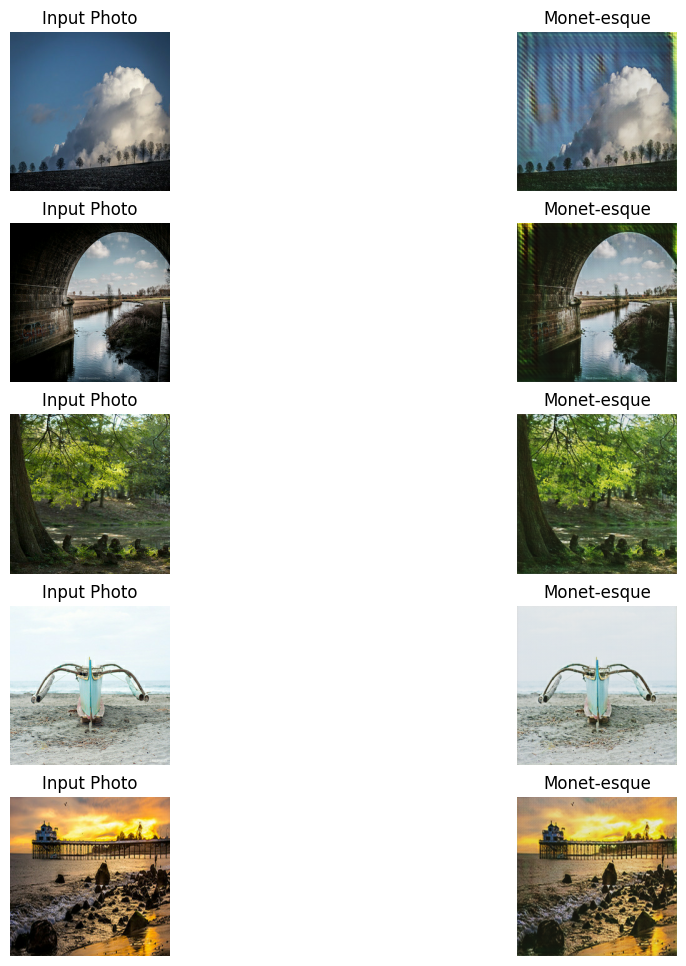

In [28]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()


# Results

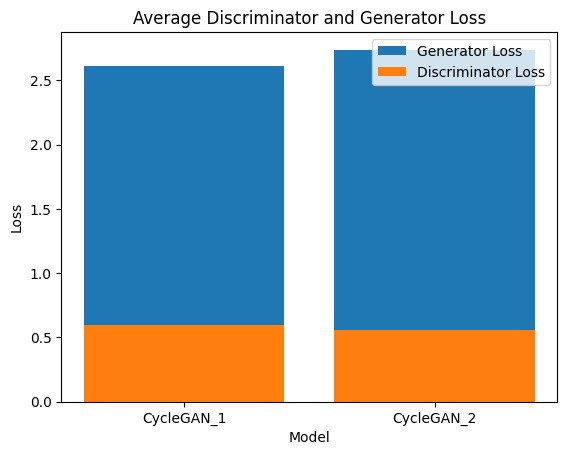

In [24]:
average_d_loss = [.59935, .55965]
average_g_loss = [2.61495, 2.7395]
model_names = ['CycleGAN_1', 'CycleGAN_2']

plt.figure()
plt.bar(model_names, average_g_loss, label='Generator Loss')
plt.bar(model_names, average_d_loss, label='Discriminator Loss')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Average Discriminator and Generator Loss')
plt.legend()
plt.show()

It makes some sense that reducing some of the layers in the generator function and increasing the number of layers in discriminator function among other updates would cause the discriminator loss to decrease and generator loss to increase.

However I did expect the higher number of epochs in the second model would help the generator loss more. Because it doesn't, I decide to favor the first Cycle GAN model.

# Prepare Images for Kaggle

In [26]:
import PIL

i = 1
for img in photo_ds:
  prediction = monet_generator(img, training=False)[0].numpy()
  prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
  im = PIL.Image.fromarray(prediction)
  im.save("/content/drive/MyDrive/Colab Notebooks/images/" + str(i) + ".jpg")
  i += 1


# Conclusion

I learned a lot about GANs during this project, including more about the concepts of image-to-image GANs and noise-to-image GANs. After playing around with different versions of CycleGAN to apply the Monet style to photos, from my experience the higher number of epochs didn't necessarily fully compensate for a simpler architecture. 

In general with GANs, unlike other areas of AI, since there isn't as much of a concern with overfitting the higher the epochs and more complex the model the better it seemed to perform.

# References

* https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

* https://keras.io/examples/generative/wgan_gp/

* https://keras.io/examples/generative/dcgan_overriding_train_step/
